In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensor_PLSA_sparse as tPLSA
import preprocessing as pre
from sklearn.metrics import roc_auc_score

In [2]:
def predict(model, src, tgt, cmt):
    like = np.log(model.p_z+1e-32)
    like += np.log(model.factors[0][src]+1e-32)
    like += np.log(model.factors[1][tgt]+1e-32)
    for word in cmt:
        like += np.log(model.factors[3][word]+1e-32)
    like -= like.max()
    p = np.exp(like)
    p = p.dot(model.factors[2].T)
    p /= p.sum()
    return p

In [3]:
def predict_set(model, srcs, tgts, cmts):
    Ntest = len(srcs)
    ps = np.zeros((Ntest,3))
    for i in range(len(srcs)):
        ps[i] = predict(model, srcs[i], tgts[i], cmts[i])
    return ps

In [4]:
def assess_roc(model, srcs, tgts, vots, cmts):
    ps = predict_set(model, srcs, tgts, cmts)
    pred = np.argmax(ps,axis=1)
    #return roc_auc_score(vots, ps, average = "macro", multi_class='ovo')
    index_binary = [i for i in range(len(vots)) if vots[i] != 1]
    labels = [vots[i]//2 for i in index_binary]
    prob_binary = ps[index_binary][:,[0,2]]
    prob_binary /= prob_binary.sum(axis=1, keepdims=True)
    #print("roc score (including neutral): ", roc_auc_score(indices_test[:,-1], probs, average = "macro", multi_class='ovo'))
    return roc_auc_score(labels, prob_binary[:,1], average = "macro")

In [5]:
def fit_model(threshold, n_class, max_iter = 10, seed = 0):
    path2data = "./wiki-RfA.txt"
    ftrain, fvalid, valid, test = pre.prepare_data(path2data,threshold=threshold)
    ftrain_counts = np.ones(len(ftrain))
    valid_srcs, valid_tgts, valid_vots, valid_cmts = valid
    ntfmp =  tPLSA.Tensor_PLSA_Sparse(n_class,n_proc=12)
    nwd = ftrain.max(axis=0)[-1]+1
    shape = (11381, 11381, 3, nwd)
    #print(shape)
    np.random.seed(seed)
    ntfmp.initialize_parameter("random", shape)
    ntfmp.prepare_fitting()
    rocs = []
    best_roc = 0
    for i in range(max_iter):
        ntfmp.optimize_once(ftrain, ftrain_counts, True)
        rocs.append(assess_roc(ntfmp, valid_srcs, valid_tgts, valid_vots, valid_cmts))
        if rocs[-1] > best_roc:
            pz = ntfmp.p_z.copy()
            factors = ntfmp.factors.copy()
            best_roc = rocs[-1]
        print(rocs[-1])
    return rocs, pz, factors

In [6]:
thresholds = [20,50,100,200,500]
n_classes = [4,8,16,32,64]
max_iter = 20
n_init = 1
best_roc = 0
rocs = np.zeros((len(thresholds), len(n_classes), n_init, max_iter))
for i in range(len(thresholds)):
    for j in range(len(n_classes)):
        print(thresholds[i], n_classes[j])
        for k in range(n_init):
            new_roc, new_pz, new_factors = fit_model(thresholds[i],n_classes[j], max_iter,k)
            rocs[i,j,k] = new_roc
            new_roc_max = max(new_roc)
            if new_roc_max > best_roc:
                best_roc = new_roc_max
                best_pz = new_pz
                best_factors = new_factors

20 4
0.6376319677049005
0.7956817883852491
0.8705098782712068
0.8886714471626135
0.8955324336242282
0.9004314072892965
0.9022536020834107
0.9019155610901883
0.9017701272234908
0.9009957165590939
0.9002035393422946
0.8991661360525823
0.897205076251184
0.8949949443607397
0.8937585012272535
0.8929536627892017
0.8919490016899326
0.8902998435862677
0.8896994906785503
0.8890240894029255
20 8
0.6791599565597584
0.8034814410321318
0.8541681216860444
0.8717316180509807
0.8793997914029763
0.8832874670382803
0.8889653780946984
0.892802544987157
0.8952147799200655
0.8950325195980049
0.8948040730468059
0.8958261263075266
0.8964064663171353
0.8968881713289232
0.8960156361998202
0.8939443012455782
0.8918354250896121
0.890173367515908
0.8888979196524343
0.8890978784558157
20 16
0.6978144281559422
0.8332133920868455
0.8789358869791319
0.8944947920857292
0.8988591014372119
0.8992432946240319
0.8992622524203694
0.899314190655937
0.8988751321770234
0.8985179632097583
0.8958663563169897
0.8930202022718587


0.8841391383807498
0.8849890739106279
0.8853379041703476
0.8851920278416171
0.8842507068841511
0.8830132767199758
0.8822584364916546
0.8805462445660559
0.8790195803744536
0.8765736162204132
0.8744956783712168
0.8732374184559492
0.8722561738088889
500 16
0.6822501794694077
0.7990378969411986
0.8544793426729581
0.8727871963195872
0.8798959274841487
0.8844482491641212
0.890013604686449
0.8947603373766193
0.8961582451166146
0.8957155107992729
0.8944738261924726
0.8929341944597491
0.891248720433836
0.8902582181196235
0.8890302498358466
0.8885622951826231
0.8878418648862539
0.8873734337354564
0.8866792788767401
0.8855635938427255
500 32
0.7578105780555442
0.862641814186912
0.8917012229514449
0.9020244748213917
0.9055082847271771
0.9058342771388853
0.9039649090849436
0.900058581973171
0.8967945395556292
0.8947569338225194
0.8926786215823722
0.8911772117621928
0.8898542162479409
0.8883575373679609
0.8870081983449741
0.8860949907443751
0.8849118132325555
0.8840396865299446
0.8833850128987892
0.

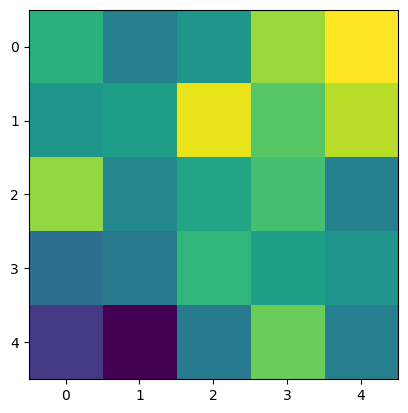

In [7]:
plt.imshow(rocs.max(axis=(2,3)))

In [20]:
np.random.seed(1)
path2data = "./wiki-RfA.txt"
threshold = 20
ftrain, fvalid, valid, test = pre.prepare_data(path2data, threshold=threshold)

In [21]:
ftrain_counts = np.ones(len(ftrain))

In [22]:
valid_srcs, valid_tgts, valid_vots, valid_cmts = valid
test_srcs, test_tgts, test_vots, test_cmts = test

In [23]:
ntfmp =  tPLSA.Tensor_PLSA_Sparse(16,n_proc=12)
shape = (11381, 11381, 3, ftrain.max(axis=0)[-1]+1)
ntfmp.initialize_parameter("random", shape)
ntfmp.prepare_fitting()
bestroc = 0
for repeat in range(10):
    rocs = []
    ntfmp =  tPLSA.Tensor_PLSA_Sparse(16,n_proc=12)
    shape = (11381, 11381, 3, ftrain.max(axis=0)[-1]+1)
    ntfmp.initialize_parameter("random", shape)
    ntfmp.prepare_fitting()
    for i in range(10):
        ntfmp.optimize_once(ftrain, ftrain_counts, True)
        rocs.append(assess_roc(ntfmp, valid_srcs, valid_tgts, valid_vots, valid_cmts))
        if i > 1 and rocs[-1] < rocs[-2] and rocs[-2] < rocs[-3]:
            break
        #print(rocs[-1])
    if rocs[-1] > bestroc:
        best_ntfmp = ntfmp

In [24]:
assess_roc(best_ntfmp, valid_srcs, valid_tgts, valid_vots, valid_cmts)

0.9034011784193432

In [25]:
assess_roc(best_ntfmp, test_srcs, test_tgts, test_vots, test_cmts)

0.9055112342398735

In [26]:
sclass = (best_ntfmp.factors[0]*best_ntfmp.p_z).argmax(axis=1)
tclass = (best_ntfmp.factors[1]*best_ntfmp.p_z).argmax(axis=1)
Pvclass = best_ntfmp.factors[2]*best_ntfmp.p_z
Pwclass = best_ntfmp.factors[3]*best_ntfmp.p_z

In [27]:
class_vot = np.zeros((16,16,3))
for i in range(len(test_srcs)):
    src_class = sclass[test_srcs[i]]
    tgt_class = tclass[test_tgts[i]]
    vot_class = test_vots[i]
    class_vot[src_class, tgt_class, vot_class] += 1

([<matplotlib.axis.YTick at 0x7f1428127dc0>,
 [Text(0, 0, '1'),
  Text(0, 1, '2'),
  Text(0, 2, '3'),
  Text(0, 3, '4'),
  Text(0, 4, '5'),
  Text(0, 5, '6'),
  Text(0, 6, '7'),
  Text(0, 7, '8'),
  Text(0, 8, '9'),
  Text(0, 9, '10'),
  Text(0, 10, '11'),
  Text(0, 11, '12'),
  Text(0, 12, '13'),
  Text(0, 13, '14'),
  Text(0, 14, '15'),
  Text(0, 15, '16')])

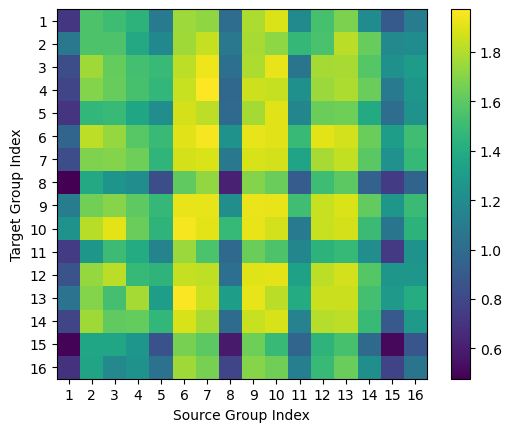

In [30]:
plt.imshow(class_vot.dot([0,1,2])/class_vot.sum(axis=2))
plt.colorbar()
plt.xlabel('Source Group Index')
plt.xticks(np.arange(16),np.arange(16)+1)
plt.ylabel('Target Group Index')
plt.yticks(np.arange(16),np.arange(16)+1)